# Credit risk

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

In this notebook, we'll create 3 models to assess credit risk by using:

- Logistic regression
- Random forests
- XGBoost

And we'll compare their performance after applying cost-sensitive learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.encoding import (
    RareLabelEncoder, 
    OrdinalEncoder, 
    OneHotEncoder,
)
from feature_engine.imputation import (
    ArbitraryNumberImputer, 
    CategoricalImputer, 
    MeanMedianImputer, 
    AddMissingIndicator,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    TunedThresholdClassifierCV,
)
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    balanced_accuracy_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## Load data

For guidelines to obtain the data, check out section 2 in the course or the `datasets` folder in this repo.

In [2]:
df = pd.read_csv("../loan_data.csv", low_memory=False)

df.head()

,new_customer,income_verification,language,age,gender,country,amount,loan_duration,use_of_loan,education,...,credit_score_microL,credit_score_equifax,credit_score_fi_asiakas,credit_score_ee_mini,nr_previous_loans,amount_previous_loans,previous_repayments,previous_early_repayments,previous_early_repayments_count,default
0,0,expenses_verified,estonian,23,male,EE,5500.0,60,loan_consolidation,secondary,...,NaN,NaN,NaN,1000.0,1,3000.0,571.73,0.0,0,0
1,0,expenses_verified,russian,25,male,EE,1200.0,60,other,vocational,...,NaN,NaN,NaN,1000.0,1,500.0,194.98,0.0,0,0
2,1,verified,finnish,28,male,FI,2000.0,60,other,higher,...,NaN,NaN,RL2,NaN,0,0.0,0.00,0.0,0,0
3,1,unverified,finnish,49,female,FI,1000.0,60,other,basic,...,NaN,NaN,RL2,NaN,0,0.0,0.00,0.0,0,0
4,0,expenses_verified,estonian,25,female,EE,4100.0,60,loan_consolidation,secondary,...,NaN,NaN,NaN,1000.0,1,1500.0,1309.03,0.0,0,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("default", axis=1),
    df["default"],
    test_size=0.10,
    random_state=10,
)

X_train.shape, X_test.shape

((90589, 31), (10066, 31))

In [4]:
# Calculate the default rate in each data set

y_train.mean(), y_test.mean()

(0.1002881144509819, 0.09944367176634214)

## Feature engineering

We'll carry out different feature engineering steps for logistic regression and tree based models.

- For logistic regression we'll impute with the mean and add missing indicators. For tree based models we'll impute with an arbitrary number.

- For logistic regression we'll do one hot encoding, for tree based models, we'll carry out ordinal encoding.

Feature-engine transformers automatically identify numerical and categorical variables, so we don't need to worry too much here.

In [5]:
numerical_vars = [c for c in X_train.columns if df[c].dtype != "O"]

In [6]:
# set up individual feature engineering steps

missing_indicators = AddMissingIndicator(variables=numerical_vars)

imputer_mean = MeanMedianImputer()
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=-1)
imputer_categorical = CategoricalImputer()

rare_encoder = RareLabelEncoder(n_categories=2)
ordinal = OrdinalEncoder(encoding_method="arbitrary")
onehot = OneHotEncoder(drop_last=True)

## Set up pipelines

### vanilla models

In [7]:
logit = Pipeline([
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("missing_indicators", missing_indicators),
    ("imputer_num", imputer_mean),
    ("encoder", onehot),
    ("model", LogisticRegression(
        penalty = 'l2',
        C = 0.1, 
        random_state=10),
    ),
]).set_output(transform="pandas")


rf = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", RandomForestClassifier(
        n_estimators = 100,
        max_depth = 4, 
        random_state=10),
    )
]).set_output(transform="pandas")


xgb = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", XGBClassifier(
        n_estimators = 100,
        max_depth =  4,
        random_state=10),
    )
]).set_output(transform="pandas")

In [8]:
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

Pipeline(steps=[('imputer_num', ArbitraryNumberImputer(arbitrary_number=-1)),
                ('imputer_cat', CategoricalImputer()),
                ('rare_categories', RareLabelEncoder(n_categories=2)),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=10, ...))])

### with CSL

xgboost does not accept the parameter `class_weight`, so for cost sensitive learning, we need to use `sample_weight` during fit.

For the sklearn models, we'll pass `class_weight` as parameter.

In [9]:
logit_csl = Pipeline([
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("missing_indicators", missing_indicators),
    ("imputer_num", imputer_mean),
    ("encoder", onehot),
    ("model", LogisticRegression(
        penalty = 'l2',
        C = 0.1,
        class_weight = {0:1, 1:10},
        random_state=10),
    ),
]).set_output(transform="pandas")


rf_csl = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", RandomForestClassifier(
        n_estimators = 100,
        max_depth = 4,
        class_weight = {0:1, 1:10},
        random_state=10),
    )
]).set_output(transform="pandas")


xgb_csl = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", XGBClassifier(
        n_estimators = 100,
        max_depth =  4,
        random_state=10),
    )
]).set_output(transform="pandas")

In [10]:
logit_csl.fit(X_train, y_train)
rf_csl.fit(X_train, y_train)

Pipeline(steps=[('imputer_num', ArbitraryNumberImputer(arbitrary_number=-1)),
                ('imputer_cat', CategoricalImputer()),
                ('rare_categories', RareLabelEncoder(n_categories=2)),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary')),
                ('model',
                 RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=4,
                                        random_state=10))])

In [11]:
# fit with sample weights

xgb_csl.fit(X_train, y_train, model__sample_weight=np.where(y_train==1,10,1))

Pipeline(steps=[('imputer_num', ArbitraryNumberImputer(arbitrary_number=-1)),
                ('imputer_cat', CategoricalImputer()),
                ('rare_categories', RareLabelEncoder(n_categories=2)),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=10, ...))])

## Evaluation

### ROC-AUC curves

We want to compare CSL vs the vanilla models.

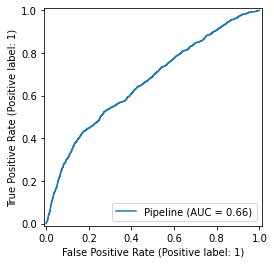

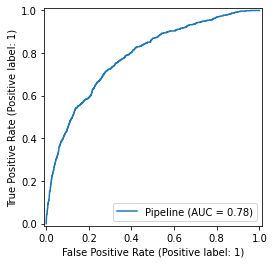

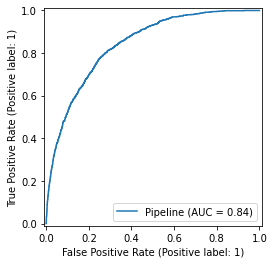

In [12]:
logit_roc = RocCurveDisplay.from_estimator(logit, X_test, y_test)
rf_roc = RocCurveDisplay.from_estimator(rf, X_test, y_test)
xgb_roc = RocCurveDisplay.from_estimator(xgb, X_test, y_test)

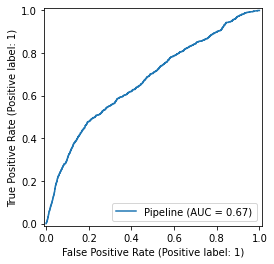

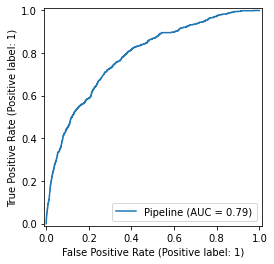

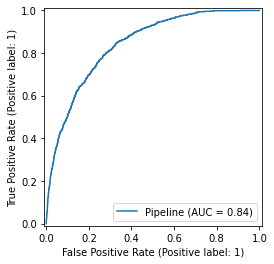

In [13]:
logit_csl_roc = RocCurveDisplay.from_estimator(logit_csl, X_test, y_test)
rf_csl_roc = RocCurveDisplay.from_estimator(rf_csl, X_test, y_test)
xgb_csl_roc = RocCurveDisplay.from_estimator(xgb_csl, X_test, y_test)

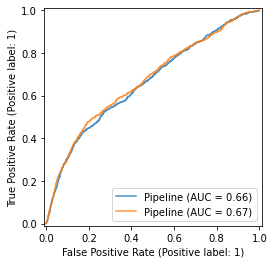

In [14]:
ax = plt.gca()
logit_roc.plot(ax=ax, alpha=0.8)
logit_csl_roc.plot(ax=ax, alpha=0.8)

Cost-sensitive learning improved a tiny bit the performance of the model.

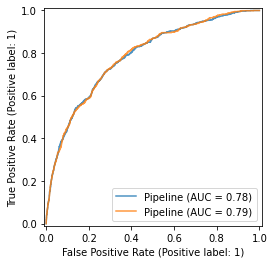

In [15]:
ax = plt.gca()
rf_roc.plot(ax=ax, alpha=0.8)
rf_csl_roc.plot(ax=ax, alpha=0.8)

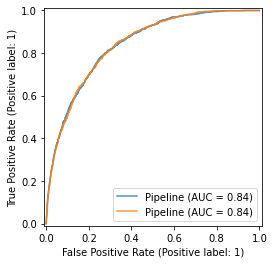

In [16]:
ax = plt.gca()
xgb_roc.plot(ax=ax, alpha=0.8)
xgb_csl_roc.plot(ax=ax, alpha=0.8)

For random forests and xgboost we do not see an increase in the performance after cost sensitive learning.

**Homework**: combine the use of CSL with hyperparameter optimization to see if you obtain better performance.

### Precision and recall curves

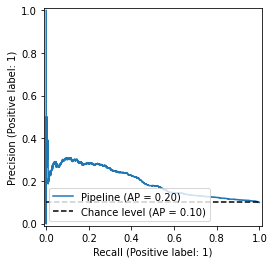

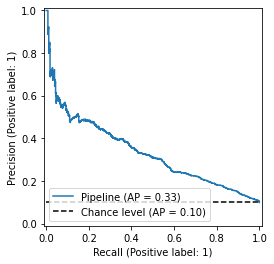

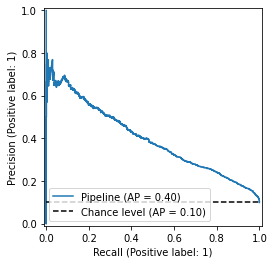

In [17]:
logit_prc = PrecisionRecallDisplay.from_estimator(logit, X_test, y_test, plot_chance_level=True)
rf_prc = PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, plot_chance_level=True)
xgb_prc = PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test, plot_chance_level=True)

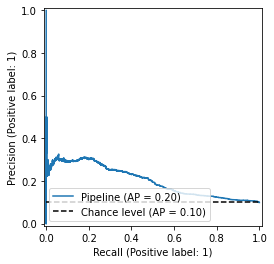

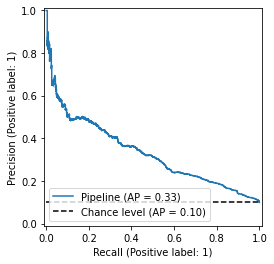

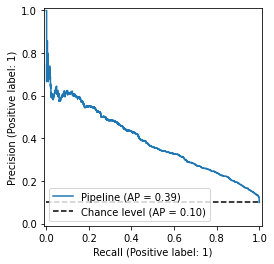

In [18]:
logit_csl_prc = PrecisionRecallDisplay.from_estimator(logit_csl, X_test, y_test, plot_chance_level=True)
rf_csl_prc = PrecisionRecallDisplay.from_estimator(rf_csl, X_test, y_test, plot_chance_level=True)
xgb_csl_prc = PrecisionRecallDisplay.from_estimator(xgb_csl, X_test, y_test, plot_chance_level=True)

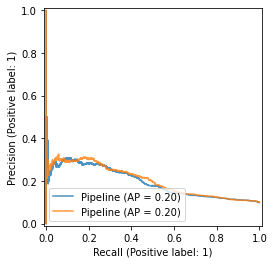

In [19]:
ax = plt.gca()
logit_prc.plot(ax=ax, alpha=0.8)
logit_csl_prc.plot(ax=ax, alpha=0.8)

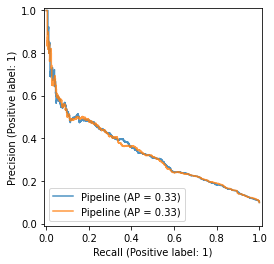

In [20]:
ax = plt.gca()
rf_prc.plot(ax=ax, alpha=0.8)
rf_csl_prc.plot(ax=ax, alpha=0.8)

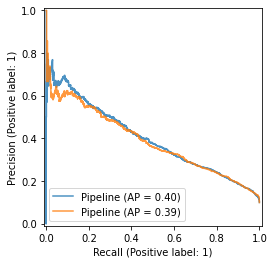

In [21]:
ax = plt.gca()
xgb_prc.plot(ax=ax, alpha=0.8)
xgb_csl_prc.plot(ax=ax, alpha=0.8)

CSL did not improve the performance of the models by looking at the PRCs.

### Balanced accuracy

We know the optimal thresholds from the section on metrics for the vanilla models.

In [22]:
def predict(prob, threshold):
    return np.where(prob[:, 1] > threshold, 1, 0)

In [23]:
logit_pred = predict(logit.predict_proba(X_test), 0.1)
rf_pred = predict(rf.predict_proba(X_test), 0.1)
xgb_pred = predict(xgb.predict_proba(X_test), 0.08)

print('Balanced Accuracy Logistic Regression test:', balanced_accuracy_score(y_test, logit_pred))
print('Balanced Accuracy Random Forest test:', balanced_accuracy_score(y_test, rf_pred))
print('Balanced Accuracy xgb test:', balanced_accuracy_score(y_test, xgb_pred))

Balanced Accuracy Logistic Regression test: 0.6211414068556926
Balanced Accuracy Random Forest test: 0.7059735631164202
Balanced Accuracy xgb test: 0.7560022988594417


In [24]:
logit_pred = predict(logit_csl.predict_proba(X_test), 0.1)
rf_pred = predict(rf_csl.predict_proba(X_test), 0.1)
xgb_pred = predict(xgb_csl.predict_proba(X_test), 0.08)

print('Balanced Accuracy Logistic Regression test:', balanced_accuracy_score(y_test, logit_pred))
print('Balanced Accuracy Random Forest test:', balanced_accuracy_score(y_test, rf_pred))
print('Balanced Accuracy xgb test:', balanced_accuracy_score(y_test, xgb_pred))

Balanced Accuracy Logistic Regression test: 0.500496414782129
Balanced Accuracy Random Forest test: 0.5
Balanced Accuracy xgb test: 0.5841667984525127


If we use the same threshold the performance deteriorates, so let's check out the optimal threshold for these models.

In [25]:
# we can optimize the threshold for sklearn models

logit_tuned = TunedThresholdClassifierCV(
    logit_csl, 
    scoring="balanced_accuracy",
    cv=3,
).fit(X_train, y_train)

rf_tuned = TunedThresholdClassifierCV(
    rf_csl, 
    scoring="balanced_accuracy",
    cv=3,
).fit(X_train, y_train)

In [26]:
logit_tuned.best_threshold_

0.5735767911441704

In [27]:
rf_tuned.best_threshold_

0.46370026040632983

In [28]:
print('Balanced Accuracy Logistic Regression:', balanced_accuracy_score(y_test, logit_tuned.predict(X_test)))
print('Balanced Accuracy Random Forest:', balanced_accuracy_score(y_test, rf_tuned.predict(X_test)))

Balanced Accuracy Logistic Regression: 0.6336061621775908
Balanced Accuracy Random Forest: 0.7094361237218381


In [29]:
# for xgboost we need to do it manually

xgb_pred = predict(xgb_csl.predict_proba(X_test), 0.5)
print('Balanced Accuracy xgb test:', balanced_accuracy_score(y_test, xgb_pred))

Balanced Accuracy xgb test: 0.7595805738662882
